In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\anaconda\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [3]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

### Random generation of time series with linear dependencies

In [4]:
length = 100000
train_length = 80000

In [5]:
max_lag = 250
min_number_of_ts = 5
max_number_of_ts = 15
coefficients_scaling = 0.4
number_of_experiments = 10

In [6]:
def generate_timeseries(n_experiments):
    result_ts = []
    targets = []
    configs = []
    for i in range(n_experiments):
        np.random.seed(i*100)
        n_ts = np.random.randint(min_number_of_ts, max_number_of_ts+1)
        X = np.random.randn(length, n_ts)
        regr_dict = {}
        lags_dict = {}
        sign_dict = {}
        coef_dict = {}
        for i in range(n_ts):
            n_coupled = np.random.randint(0, n_ts)
            regressors = np.random.choice(np.arange(0, n_ts), n_coupled, replace=False)
            regr_dict[i] = regressors
            lags = np.random.choice(np.arange(1, max_lag), n_coupled, replace=False)
            lags_dict[i] = lags
            sign_dict[i] = []
            for k in range(n_coupled):
                sign = np.random.randint(0, 2)
                sign = sign*2 - 1
                sign_dict[i].append(sign)
            coefs = np.random.rand(n_coupled)*coefficients_scaling
            coef_dict[i] = coefs
            
        for j in range(length):
            for i in range(n_ts):
                for regr, lag, sign, coef in zip(regr_dict[i], lags_dict[i], sign_dict[i], coef_dict[i]):
                    X[j, i] += sign*coef*X[j-lag, regr]
        result_ts.append(X)
        target = np.random.randint(0, n_ts)
        while len(regr_dict[target]) == 0:
            target = np.random.randint(0, n_ts)
        targets.append(target)
        configs.append([regr_dict, lags_dict, sign_dict, coef_dict])
    return result_ts, targets, configs

In [7]:
Xs, targets, configs = generate_timeseries(number_of_experiments)

### Examples of generated time series


0 0


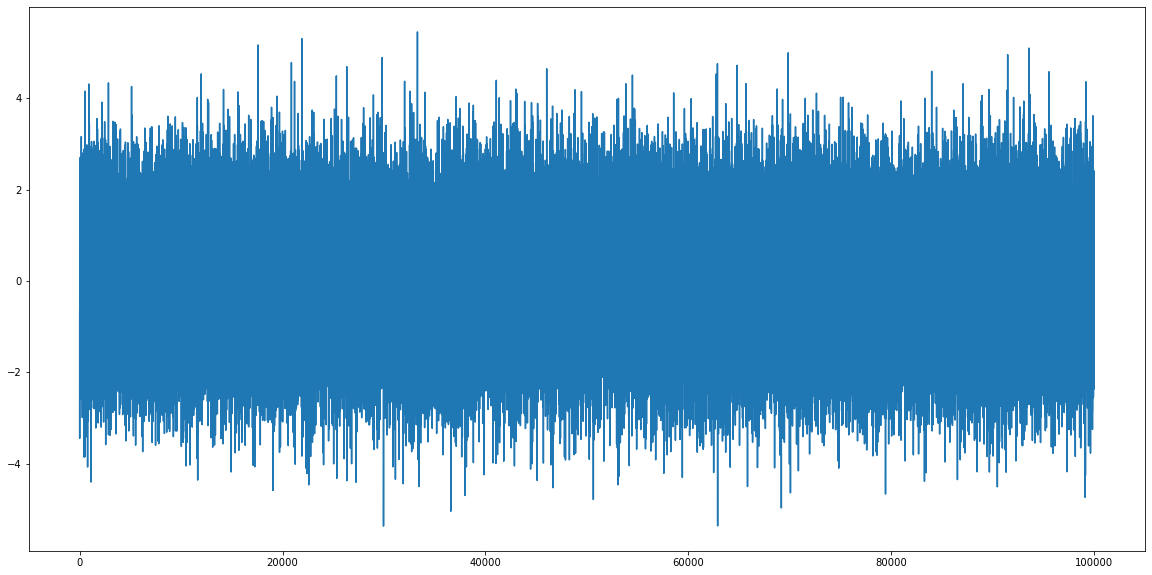

1 0


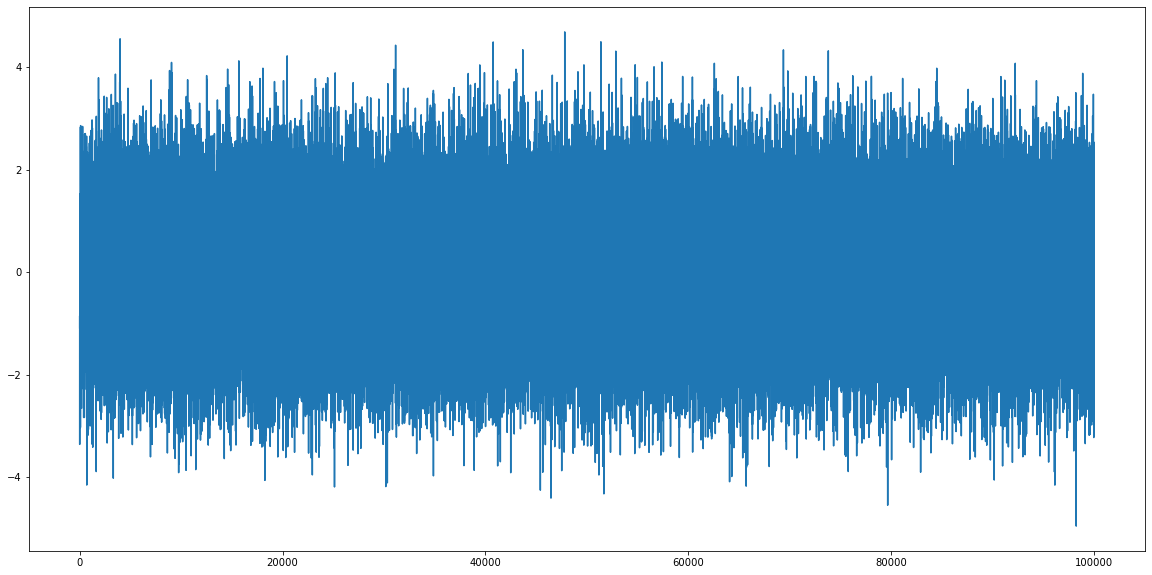

2 0


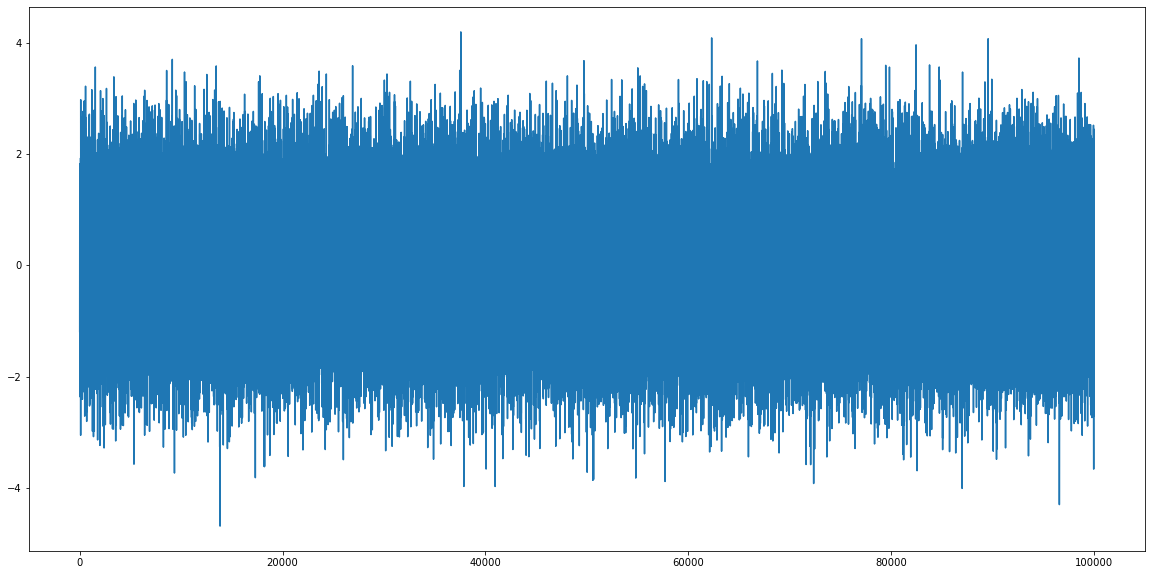

3 0


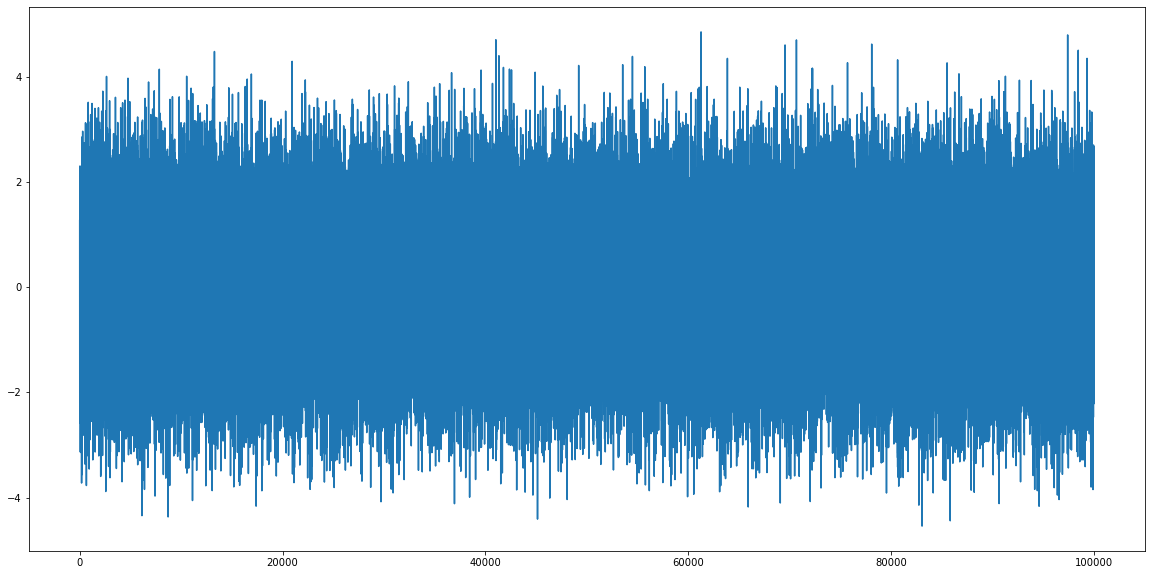

4 0


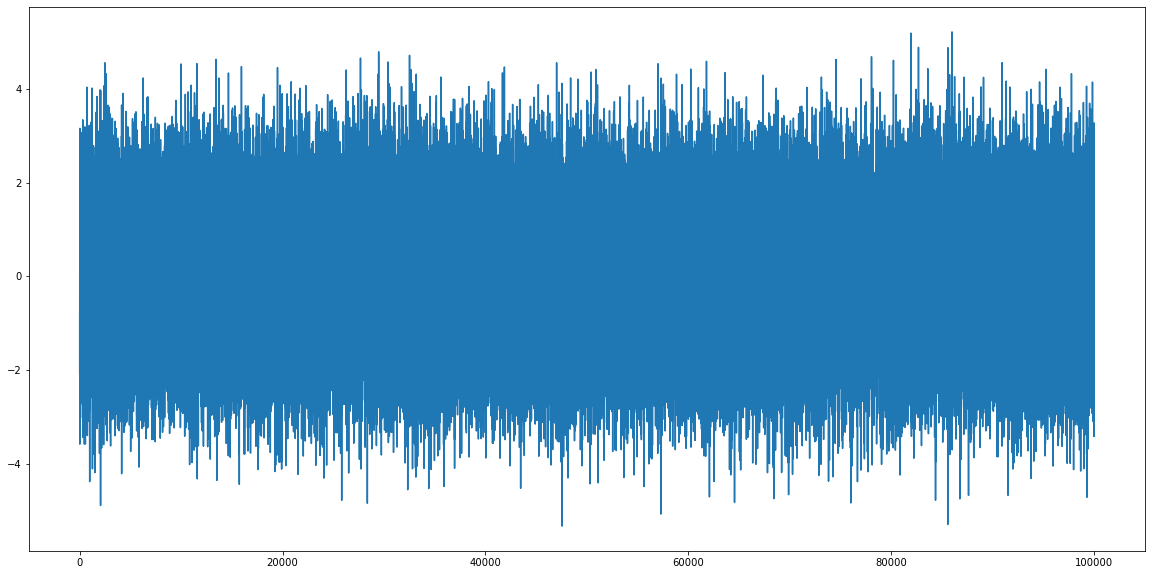

5 0


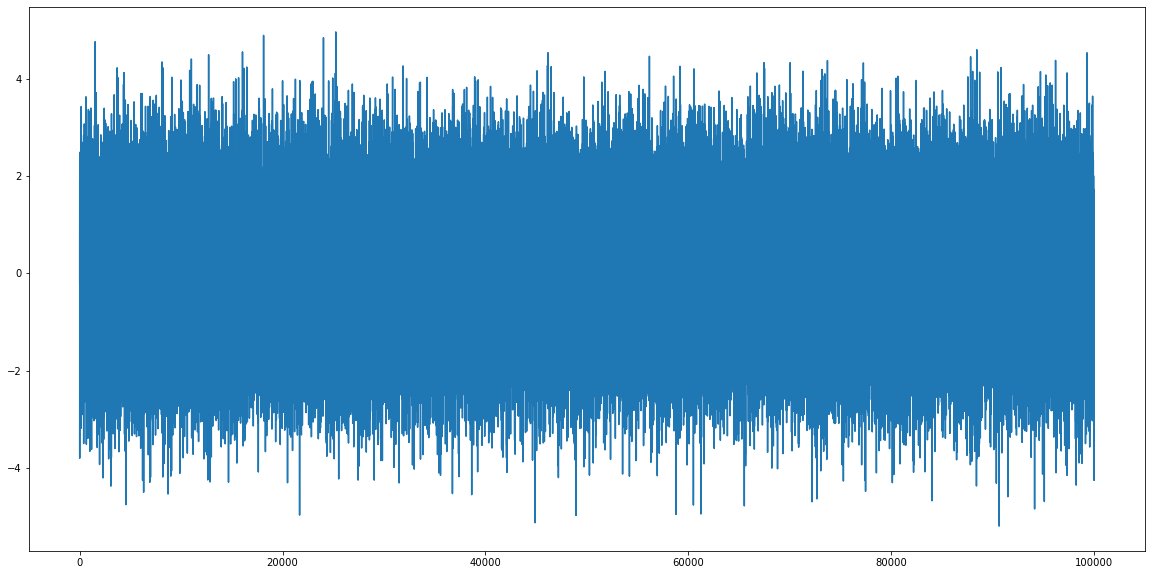

6 0


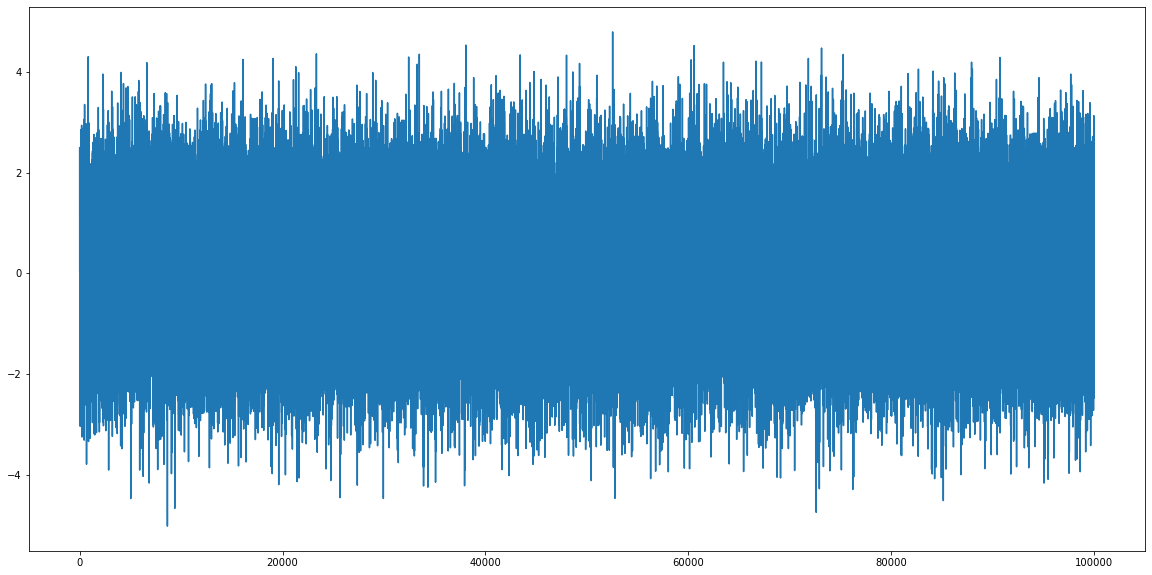

7 0


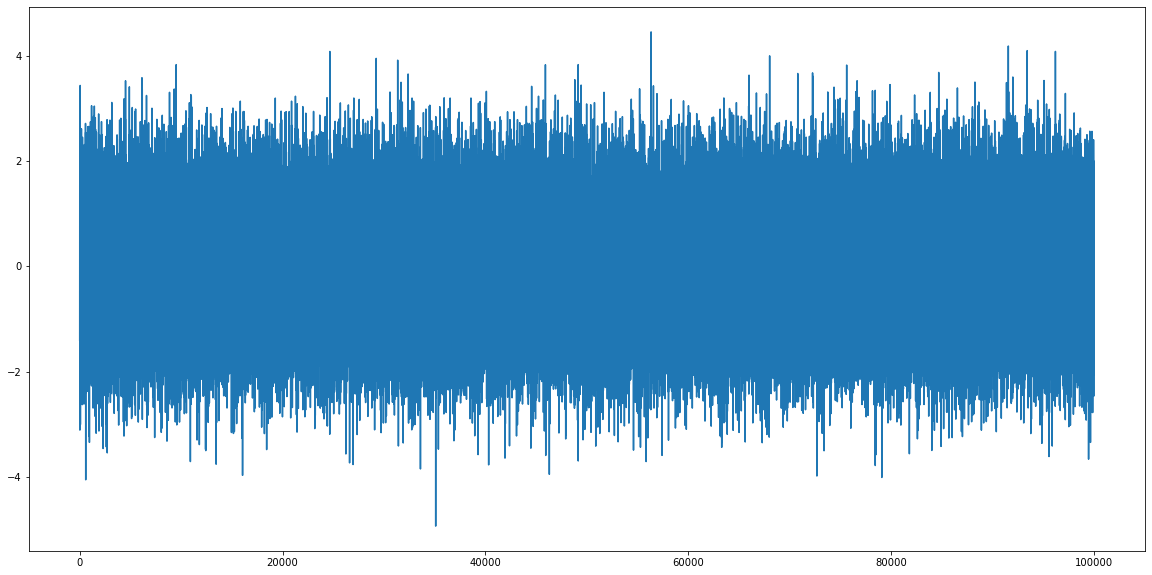

8 0


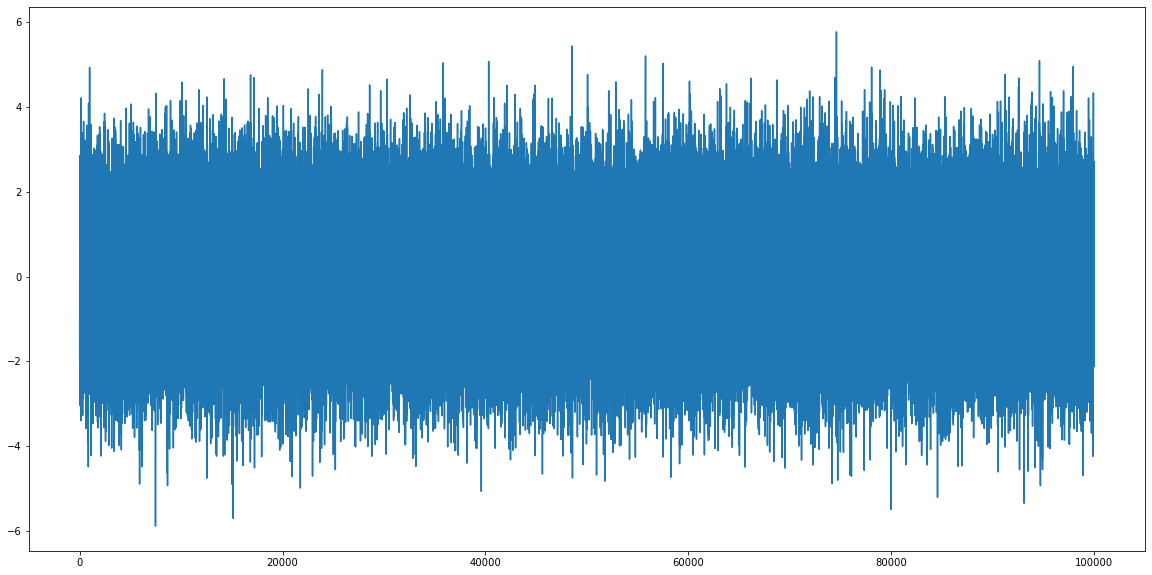

9 0


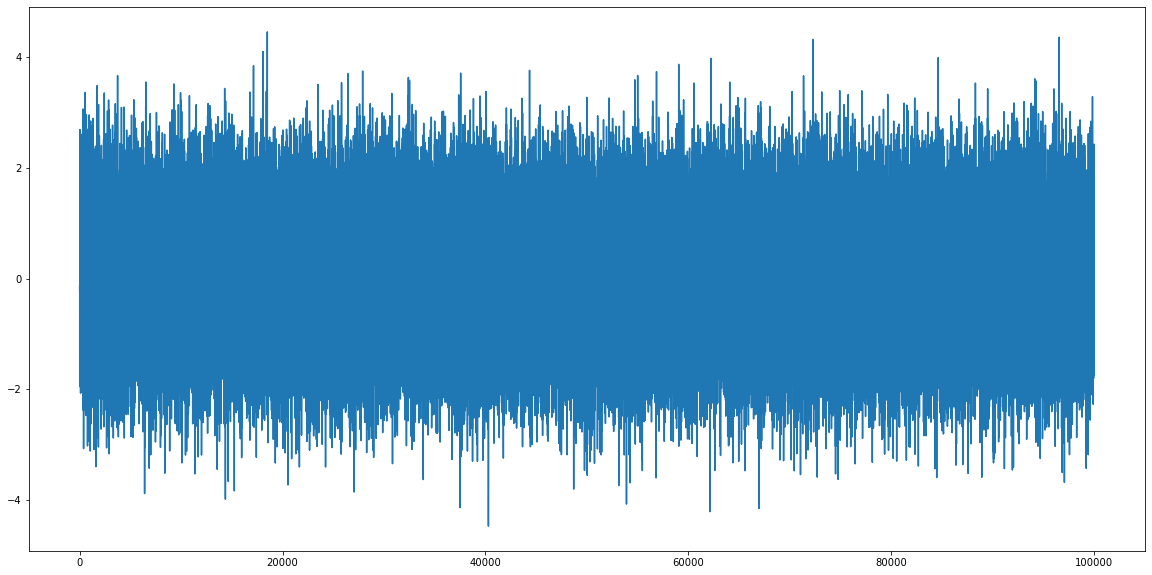

In [8]:
for i in range(len(Xs)):
    for j in range(Xs[i].shape[1]):
        plt.figure(figsize=(20, 10))
        print(i, j)
        plt.plot(Xs[i][:, j])
        plt.show()
        break

### Obtained equations

In [9]:
print("Equations obtained")
for k in range(len(configs)):
    print("Case ", k+1)
    for key in configs[k][0].keys():
        eq = "X{} = ".format(key)
        for  regr, ts, sign,  coef in zip(configs[k][0][key], configs[k][1][key],
                                         configs[k][2][key], configs[k][3][key]):
            if(sign == 1):
                eq += "+"
            eq += str(sign*round(coef, 3)) + "X{}".format(regr) + "[t-{}]".format(ts) + " "
        eq += "+ n~N(0, 1)"
        print(eq)
        print("")

Equations obtained
Case  1
X0 = +0.129X7[t-249] -0.104X1[t-206] +0.374X4[t-55] -0.334X0[t-140] +0.341X2[t-89] + n~N(0, 1)

X1 = +0.235X1[t-182] +0.129X4[t-205] +0.149X2[t-122] -0.399X6[t-77] + n~N(0, 1)

X2 = -0.012X8[t-184] +0.106X7[t-200] + n~N(0, 1)

X3 = -0.312X6[t-140] -0.374X8[t-246] -0.035X9[t-136] -0.375X7[t-165] +0.072X1[t-60] -0.341X3[t-182] +0.209X4[t-174] +0.162X2[t-5] + n~N(0, 1)

X4 = -0.078X4[t-164] +0.201X3[t-213] -0.187X2[t-147] -0.037X1[t-89] + n~N(0, 1)

X5 = -0.239X8[t-78] -0.269X6[t-197] +0.254X5[t-187] +0.37X2[t-179] +0.1X1[t-69] +0.383X3[t-77] -0.073X9[t-84] +0.253X0[t-152] + n~N(0, 1)

X6 = +0.123X2[t-196] +0.241X5[t-152] + n~N(0, 1)

X7 = -0.267X6[t-221] -0.393X1[t-220] -0.286X4[t-151] -0.075X7[t-126] -0.256X9[t-247] +0.014X0[t-44] + n~N(0, 1)

X8 = +0.157X9[t-43] -0.185X3[t-73] +0.399X4[t-180] +0.199X7[t-131] -0.385X8[t-210] +0.355X0[t-21] + n~N(0, 1)

X9 = +0.103X2[t-86] +0.052X7[t-42] +0.126X1[t-2] + n~N(0, 1)

Case  2
X0 = -0.224X7[t-109] -0.353X1[t-124] +0

### Calculating dependencies for  randomly chosen targets

In [11]:
class GRUnet(nn.Module):
    def __init__(self, input_dim, n_units=32, n_layers=1, p=0.0, leak=0.01):
        super().__init__()
        self.gru = nn.GRU(input_dim, n_units, batch_first=True, num_layers=n_layers)
        self.drop = nn.Dropout(p)
        self.d1 = nn.Linear(n_units, 2*n_units)
        self.d2 = nn.Linear(2*n_units, 1)
        self.lrelu = nn.LeakyReLU(leak)
    def forward(self, x):
        out, h = self.gru(x)
        out = self.drop(h[-1])
        out = self.d2(self.lrelu(self.d1(out)))
        return out.squeeze(1) 

In [12]:
depth = 300
epochs = 100
importance_calculation_steps = 20
early_stopping_epochs = 10

regularizer_coeff1 = 0.005
regularizer_coeff2 = 0.0001
scaling_coeff = 0.5
importance_lr = 0.1
importance_threshold = 0.005

In [13]:
maps = []
results = []

In [14]:
from tqdm import tqdm_notebook

In [15]:
for k in range(len(Xs)):
    print("Case: ", k+1)
    X = np.zeros((length, depth, Xs[k].shape[1]))
    for i in tqdm_notebook(range(Xs[k].shape[1])):
        for j in range(depth):
            X[:, j, i] = pd.Series(Xs[k][:, i]).shift(depth - j - 1).bfill()
    
    y = pd.Series(Xs[k][:, targets[k]]).shift(-1).ffill().values
    
    X_train = X[:train_length]
    X_test = X[train_length:]
    y_train = y[:train_length]
    y_test = y[train_length:]
    
    X_train_t = torch.Tensor(X_train)
    X_test_t = torch.Tensor(X_test)
    y_train_t = torch.Tensor(y_train)
    y_test_t = torch.Tensor(y_test)
    
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=64)
    test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=64)
    
    #model = TCNModel(X_train_t.shape[2], num_channels=[32] * 9, kernel_size=3, dropout=0.0).cuda()
    model = GRUnet(X_train_t.shape[2], n_units=128).cuda()
    

    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    sc = torch.optim.lr_scheduler.StepLR(opt, 10, 0.8)
    loss = nn.MSELoss()
    
    
    val_loss = 999
    counter = 0
    
    print("Training")
    for e in range(epochs):
        train_loss = 0
        model.train()
        for batch_x, batch_y in tqdm_notebook(train_loader):
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            opt.zero_grad()
            output = model(batch_x)
            l = loss(output, batch_y)
            l.backward()
            opt.step()
            train_loss+=l.item()*batch_x.shape[0]
        true = []
        preds = []
        model.eval()
        sc.step()
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x = batch_x.cuda()
                output = model(batch_x)
                true.append(batch_y.numpy())
                preds.append(output.detach().cpu().numpy())
        preds = np.concatenate(preds)
        true = np.concatenate(true)
        mse = mean_squared_error(true, preds)
        r2 = r2_score(true, preds)
        print("Iter: ", e, "train: ", train_loss/len(X_train_t), "mse: ", mse, "r2: ", r2)
        if val_loss > mse:
            val_loss = mse
            torch.save(model.state_dict(), "gru_{}.pt".format(k))
        else:
            counter += 1
        
        if counter == early_stopping_epochs:
            break
    model.load_state_dict(torch.load('gru_{}.pt'.format(k)))
    
    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()
    
    model.train()
    
    print("Calculating Importance:")
    importance_map = []
    for batch_x, batch_y in tqdm_notebook(test_loader):
        batch_x = batch_x.cuda()
        #batch_y = batch_y.cuda()
        bx = batch_x
        y = model(batch_x)
        mask = nn.Parameter(-scaling_coeff*torch.randn_like(bx))
        opt = torch.optim.RMSprop(nn.ParameterList([mask]), lr=importance_lr)
        for e in range(importance_calculation_steps):
            opt.zero_grad()
            model.zero_grad()
            #model.eval()
            y = y.detach()
            M = torch.sigmoid(mask)
            x_hat = bx*M
            y_hat = model(x_hat)
            l = mse_loss(y_hat, y)
            l += regularizer_coeff1*torch.sum(torch.abs(M))
            ones = torch.zeros_like(bx)
            ones[M>0.5] = 1
            l += 0.5*bce_loss(M, ones)
            l.backward()
            opt.step()
        M = torch.sigmoid(mask)
        #ms = ms.detach().cpu().numpy()
        thresholds = {}
        with torch.no_grad():
            for t in np.linspace(M.min().item(), M.max().item(), 100):
                M_clone = M.clone()
                M_clone[M_clone>t] = 1
                M_clone[M_clone<=t] = 0
                x_hat = bx*M_clone
                y_hat = model(x_hat)
                l = mse_loss(y_hat, y)
                l += regularizer_coeff2*torch.sum(torch.abs(M_clone))
                thresholds[l.item()] = t
        t = thresholds[min(thresholds.keys())]
        M = M.detach().cpu().numpy()
        M[M>t] = 1
        M[M<=t] = 0
        importance_map.append(np.abs(M))
        
    importance_map = np.concatenate(importance_map)
    importance_map = np.mean(importance_map, axis=0)
    
    maps.append(importance_map)
    result = {}
    for i in range(importance_map.shape[1]):
        max_val = importance_map[:, i].max()
        if max_val > importance_threshold:
            timestep = importance_map.shape[0] - np.argmax(importance_map[:, i])
            result[i] = timestep
    
    FP, TP, FN = 0, 0, 0
    for regr, ts in zip(configs[k][0][targets[k]], configs[k][1][targets[k]]):
        predicted_timestep = result.get(regr)
        if predicted_timestep is None:
            FN += 1
        elif predicted_timestep != ts:
            FP += 1
            FN += 1
        else:
            TP += 1

    for regr in result.keys():
        if regr not in configs[k][0][targets[k]]:
            FP += 1
            
    precision = TP/(TP + FP + 1e-9)
    recall = TP/(TP + FN + 1e-9)
    print("Results: ", precision, recall)
    results.append([precision, recall])

Case:  1


<ipython-input-15-986dcef907c4>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(Xs[k].shape[1])):



Training


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  0 train:  1.8400570031166077 mse:  1.8419734 r2:  0.0010017947106135683


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  1 train:  1.834299929380417 mse:  1.8439134 r2:  -5.0432661889532326e-05


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  2 train:  1.8309768321037292 mse:  1.8339787 r2:  0.005337627384181309


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  3 train:  1.8254962280750275 mse:  1.8356688 r2:  0.004421185225290447


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  4 train:  1.817119584608078 mse:  1.8279449 r2:  0.008610035472247146


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  5 train:  1.8064448884963988 mse:  1.83481 r2:  0.004886890482075024


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  6 train:  1.7948670729637146 mse:  1.8407542 r2:  0.001662990572772971


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  7 train:  1.775501436471939 mse:  1.8468447 r2:  -0.0016403131138769123


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  8 train:  1.7461316663265227 mse:  1.875448 r2:  -0.01715329124254006


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  9 train:  1.7000593241214752 mse:  1.9141824 r2:  -0.03816098252662692


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  10 train:  1.6274924880981445 mse:  1.9559904 r2:  -0.06083571144257949


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  11 train:  1.5575844887256622 mse:  2.0024042 r2:  -0.08600839372956615


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  12 train:  1.4809668875217439 mse:  2.1017919 r2:  -0.13991131308375948
Calculating Importance:


<ipython-input-15-986dcef907c4>:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(test_loader):



Results:  0.9999999989999999 0.124999999984375
Case:  2


<ipython-input-15-986dcef907c4>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(Xs[k].shape[1])):



Training


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  0 train:  1.199670202922821 mse:  1.2119402 r2:  -0.00039046305236989376


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  1 train:  1.1981897718191148 mse:  1.2113124 r2:  0.0001276678705935952


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  2 train:  1.1979139523506164 mse:  1.211379 r2:  7.271955375653949e-05


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  3 train:  1.1966188483715057 mse:  1.2119392 r2:  -0.0003898192529387945


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  4 train:  1.1946964014053345 mse:  1.2134991 r2:  -0.0016773536803154077


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  5 train:  1.1887845154762269 mse:  1.2188008 r2:  -0.006053548766964623


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  6 train:  1.1784930603027344 mse:  1.2302971 r2:  -0.015542993311334685


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  7 train:  1.1592420549392701 mse:  1.2465689 r2:  -0.028974601536507105


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  8 train:  1.1281951034069062 mse:  1.2673124 r2:  -0.04609722381888548


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  9 train:  1.0860595427036286 mse:  1.3203042 r2:  -0.08983908515011052


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  10 train:  1.0210031455039978 mse:  1.3765799 r2:  -0.13629159900527044


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  11 train:  0.962987378334999 mse:  1.4170787 r2:  -0.16972116406753268
Calculating Importance:


<ipython-input-15-986dcef907c4>:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(test_loader):



Results:  0.0 0.0
Case:  3


<ipython-input-15-986dcef907c4>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(Xs[k].shape[1])):



Training


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  0 train:  1.614357578086853 mse:  1.6098137 r2:  -0.000706165257733371


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  1 train:  1.6112345665454864 mse:  1.6078305 r2:  0.0005266139892270427


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  2 train:  1.6064164712429048 mse:  1.6042249 r2:  0.002767862298034607


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  3 train:  1.6008357759475709 mse:  1.6029911 r2:  0.0035348499943396172


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  4 train:  1.5937283690929414 mse:  1.6156181 r2:  -0.004314428900029199


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  5 train:  1.5824392409801482 mse:  1.6019878 r2:  0.004158579799834472


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  6 train:  1.5684097192287445 mse:  1.606961 r2:  0.0010670955186843356


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  7 train:  1.5455468321323396 mse:  1.6257343 r2:  -0.010602980836544651


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  8 train:  1.5159151314258577 mse:  1.6301358 r2:  -0.013339003103641112


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  9 train:  1.4758394809722901 mse:  1.6874584 r2:  -0.04897239546879173


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  10 train:  1.408378675031662 mse:  1.7501246 r2:  -0.08792748761580316


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  11 train:  1.3488968571662903 mse:  1.8187633 r2:  -0.1305953645886644


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  12 train:  1.2881425105571747 mse:  1.8943363 r2:  -0.1775735529294824


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  13 train:  1.2229853823184966 mse:  1.9453963 r2:  -0.20931393221736716


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  14 train:  1.1581464009284974 mse:  2.0224118 r2:  -0.25718910440118625
Calculating Importance:


<ipython-input-15-986dcef907c4>:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(test_loader):



Results:  0.0 0.0
Case:  4


<ipython-input-15-986dcef907c4>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(Xs[k].shape[1])):



Training


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  0 train:  1.139309645318985 mse:  1.1267389 r2:  0.012732550309101587


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  1 train:  1.1327672881603241 mse:  1.1271678 r2:  0.012356665699947977


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  2 train:  1.1323785998344422 mse:  1.1262176 r2:  0.013189455195168232


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  3 train:  1.1316899821281432 mse:  1.1252881 r2:  0.014003816767589217


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  4 train:  1.1311888857841492 mse:  1.1262285 r2:  0.013179892574434193


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  5 train:  1.130397609424591 mse:  1.1247298 r2:  0.014492943869679809


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  6 train:  1.1291297033309937 mse:  1.1260265 r2:  0.013356711291555134


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  7 train:  1.127313405561447 mse:  1.1277635 r2:  0.011834849840777095


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  8 train:  1.1235715484142303 mse:  1.1286315 r2:  0.011074186453559842


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  9 train:  1.1189706840991973 mse:  1.134543 r2:  0.005894506683394418


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  10 train:  1.1070858718395233 mse:  1.1394897 r2:  0.0015602016422203713


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  11 train:  1.0917955122947693 mse:  1.1478179 r2:  -0.00573713934799569


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  12 train:  1.071920690202713 mse:  1.1768447 r2:  -0.031171041749865624


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  13 train:  1.044085917711258 mse:  1.1884046 r2:  -0.04129995540855291
Calculating Importance:


<ipython-input-15-986dcef907c4>:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(test_loader):



Results:  0.0 0.0
Case:  5


<ipython-input-15-986dcef907c4>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(Xs[k].shape[1])):



Training


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  0 train:  1.0014018010616303 mse:  1.0028342 r2:  -5.366780960303075e-06


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  1 train:  1.0002133570671081 mse:  1.0030596 r2:  -0.00023017516997780874


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  2 train:  1.0000910422325133 mse:  1.004103 r2:  -0.001270417687972758


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  3 train:  0.9993433165550232 mse:  1.0062972 r2:  -0.0034586564798508856


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  4 train:  0.9982092543125153 mse:  1.0054032 r2:  -0.0025671008698271436


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  5 train:  0.9956284875392913 mse:  1.0091168 r2:  -0.006270196698304975


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  6 train:  0.9887858733177185 mse:  1.0143555 r2:  -0.011494235600664648


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  7 train:  0.9750832887649536 mse:  1.0306479 r2:  -0.027740524879409367


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  8 train:  0.9505157885074615 mse:  1.0403908 r2:  -0.03745606090295017


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  9 train:  0.9147449667453766 mse:  1.0888357 r2:  -0.08576434901617946


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  10 train:  0.8600077992677688 mse:  1.1206634 r2:  -0.11750213715501068
Calculating Importance:


<ipython-input-15-986dcef907c4>:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(test_loader):



Results:  0.0 0.0
Case:  6


<ipython-input-15-986dcef907c4>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(Xs[k].shape[1])):



Training


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  0 train:  1.395524589586258 mse:  1.4053993 r2:  1.2739327386435129e-05


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  1 train:  1.3943866241931915 mse:  1.4062719 r2:  -0.0006080571855480166


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  2 train:  1.3938054329395295 mse:  1.406276 r2:  -0.0006109951246240364


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  3 train:  1.3931647856712341 mse:  1.4084291 r2:  -0.0021431535709028893


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  4 train:  1.3914822538852691 mse:  1.4072309 r2:  -0.001290418029749274


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  5 train:  1.3866728163719177 mse:  1.4123361 r2:  -0.004922981677682126


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  6 train:  1.3764118146419526 mse:  1.4322809 r2:  -0.01911433799120643


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  7 train:  1.3524512698173523 mse:  1.4516981 r2:  -0.03293025214421452


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  8 train:  1.3096715698719024 mse:  1.484792 r2:  -0.05647770801442187


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  9 train:  1.2505556572914123 mse:  1.5198966 r2:  -0.08145584064933775


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  10 train:  1.1621521534442902 mse:  1.5931917 r2:  -0.13360769558220364
Calculating Importance:


<ipython-input-15-986dcef907c4>:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(test_loader):



Results:  0.0 0.0
Case:  7


<ipython-input-15-986dcef907c4>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(Xs[k].shape[1])):



Training


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  0 train:  1.1283269464015961 mse:  1.1244882 r2:  0.00010534626515312784


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  1 train:  1.127379107427597 mse:  1.1247373 r2:  -0.00011607724637641148


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  2 train:  1.127323694753647 mse:  1.1247859 r2:  -0.00015928148347899018


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  3 train:  1.1273775694847108 mse:  1.1247 r2:  -8.27994859473602e-05


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  4 train:  1.1273106153964996 mse:  1.1249831 r2:  -0.00033473458097454944


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  5 train:  1.1269678358078004 mse:  1.1247767 r2:  -0.00015112473496836643


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  6 train:  1.1265548488616943 mse:  1.1263727 r2:  -0.0015702144093363568


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  7 train:  1.1258011302948 mse:  1.1257489 r2:  -0.0010154336080778759


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  8 train:  1.1244035239696504 mse:  1.1272093 r2:  -0.002314095161214391


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  9 train:  1.1216592895030975 mse:  1.1305864 r2:  -0.005317011889056422


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  10 train:  1.1147127034187316 mse:  1.1356965 r2:  -0.0098610392530325
Calculating Importance:


<ipython-input-15-986dcef907c4>:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(test_loader):



Results:  0.0 0.0
Case:  8


<ipython-input-15-986dcef907c4>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(Xs[k].shape[1])):



Training


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  0 train:  1.6305341671943665 mse:  1.59887 r2:  0.0076784182989921845


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  1 train:  1.6204243285179138 mse:  1.6007447 r2:  0.006514897754341886


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  2 train:  1.615446802330017 mse:  1.594758 r2:  0.010230601121149818


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  3 train:  1.6111105249404907 mse:  1.5925566 r2:  0.011596825812747125


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  4 train:  1.604189069890976 mse:  1.5975552 r2:  0.008494564644184077


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  5 train:  1.5923573966503144 mse:  1.6030492 r2:  0.005084697130630755


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  6 train:  1.5747955206871034 mse:  1.6096392 r2:  0.0009946492696036868


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  7 train:  1.5476101392745971 mse:  1.625367 r2:  -0.008766629113218016


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  8 train:  1.507111010837555 mse:  1.6525536 r2:  -0.02563964543042263


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  9 train:  1.4537516574382783 mse:  1.7434765 r2:  -0.08207000602028613


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  10 train:  1.3727450031280517 mse:  1.7924728 r2:  -0.11247911747110617


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  11 train:  1.2989344537258147 mse:  1.8032018 r2:  -0.11913783558794822


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  12 train:  1.226539683675766 mse:  1.9369811 r2:  -0.20216655472504041
Calculating Importance:


<ipython-input-15-986dcef907c4>:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(test_loader):



Results:  0.0 0.0
Case:  9


<ipython-input-15-986dcef907c4>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(Xs[k].shape[1])):



Training


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  0 train:  1.942498905467987 mse:  1.8973484 r2:  0.02744581655053402


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  1 train:  1.8859613425254822 mse:  1.8555608 r2:  0.048865517146601034


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  2 train:  1.8518369178771972 mse:  1.8411565 r2:  0.05624896977220051


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  3 train:  1.8247412197113038 mse:  1.8304759 r2:  0.0617236597797588


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  4 train:  1.7991168739318848 mse:  1.8323987 r2:  0.06073813771373471


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  5 train:  1.7726076608181 mse:  1.864572 r2:  0.044246516786598855


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  6 train:  1.7433708555221559 mse:  1.8830692 r2:  0.03476511595379872


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  7 train:  1.7019459910869599 mse:  1.8934797 r2:  0.029428792947624793


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  8 train:  1.6539761869430543 mse:  1.9412053 r2:  0.004965421158762862


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  9 train:  1.5992232721805573 mse:  1.9594322 r2:  -0.004377502660076749


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  10 train:  1.5137968727111817 mse:  2.05184 r2:  -0.05174451951879533


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  11 train:  1.4450864688396454 mse:  2.1545684 r2:  -0.10440151950496057


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  12 train:  1.3794229716777802 mse:  2.2218282 r2:  -0.13887798635198179


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  13 train:  1.3099798874855042 mse:  2.2746706 r2:  -0.16596428655750617
Calculating Importance:


<ipython-input-15-986dcef907c4>:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(test_loader):



Results:  0.49999999975 0.09090909090082644
Case:  10


<ipython-input-15-986dcef907c4>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(Xs[k].shape[1])):



Training


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  0 train:  1.3458830976009368 mse:  1.3427943 r2:  -7.530876624173288e-05


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  1 train:  1.3445168213844298 mse:  1.345283 r2:  -0.001928877768520243


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  2 train:  1.3444370606422424 mse:  1.3427116 r2:  -1.362781888625264e-05


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  3 train:  1.3439121704101562 mse:  1.3444874 r2:  -0.0013362289504152969


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  4 train:  1.3430869117736817 mse:  1.344641 r2:  -0.0014507149317841694


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  5 train:  1.3415264126300812 mse:  1.3452208 r2:  -0.001882414559729817


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  6 train:  1.33787616314888 mse:  1.344708 r2:  -0.0015004284742357044


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  7 train:  1.3307142156600953 mse:  1.3554152 r2:  -0.009475069453229512


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  8 train:  1.31788627243042 mse:  1.3666716 r2:  -0.01785839554982016


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  9 train:  1.297722604370117 mse:  1.3738465 r2:  -0.023202136405723328


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  10 train:  1.2566546530246734 mse:  1.4150506 r2:  -0.05388978956901003


<ipython-input-15-986dcef907c4>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(train_loader):



Iter:  11 train:  1.2125893138885497 mse:  1.430349 r2:  -0.06528361678685268
Calculating Importance:


<ipython-input-15-986dcef907c4>:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(test_loader):



Results:  0.0 0.0


In [16]:
for i, r in enumerate(results):
    print('Case {}'.format(i+1))
    print('Precision', 'Recall')
    print(r)

Case 1
Precision Recall
[0.9999999989999999, 0.124999999984375]
Case 2
Precision Recall
[0.0, 0.0]
Case 3
Precision Recall
[0.0, 0.0]
Case 4
Precision Recall
[0.0, 0.0]
Case 5
Precision Recall
[0.0, 0.0]
Case 6
Precision Recall
[0.0, 0.0]
Case 7
Precision Recall
[0.0, 0.0]
Case 8
Precision Recall
[0.0, 0.0]
Case 9
Precision Recall
[0.49999999975, 0.09090909090082644]
Case 10
Precision Recall
[0.0, 0.0]


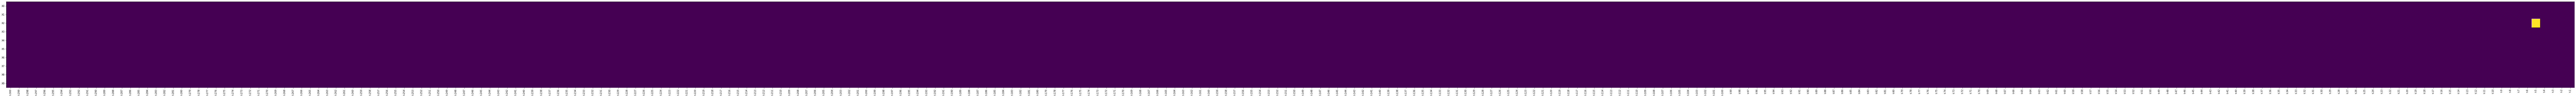

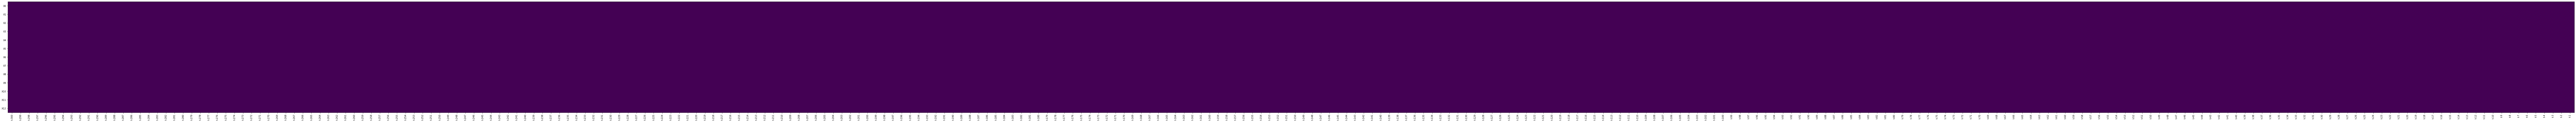

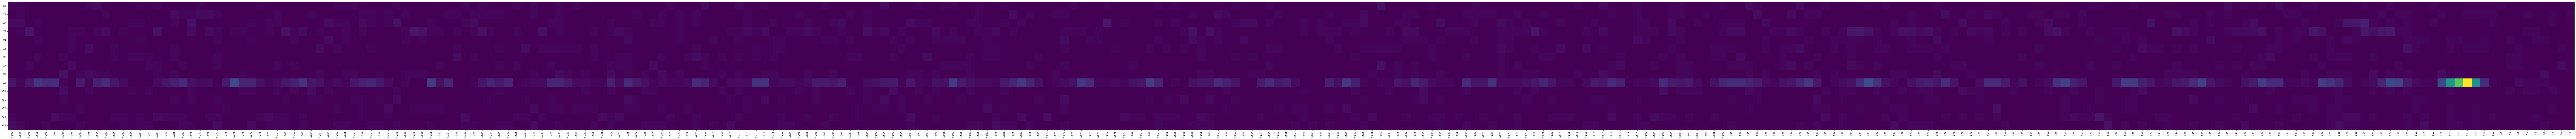

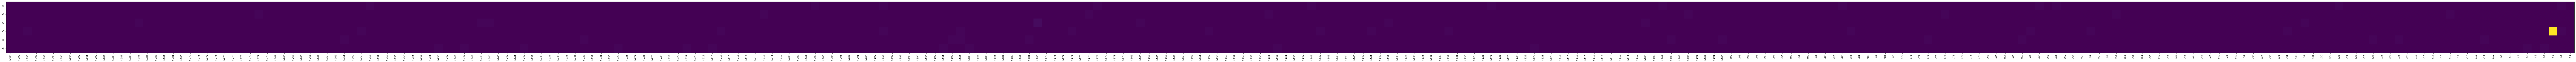

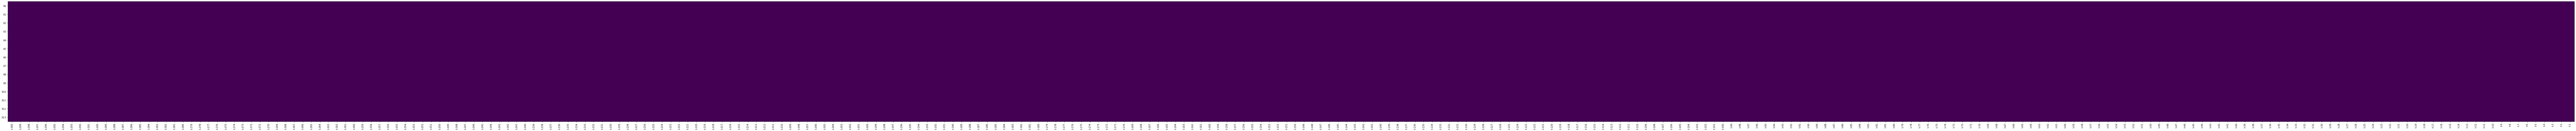

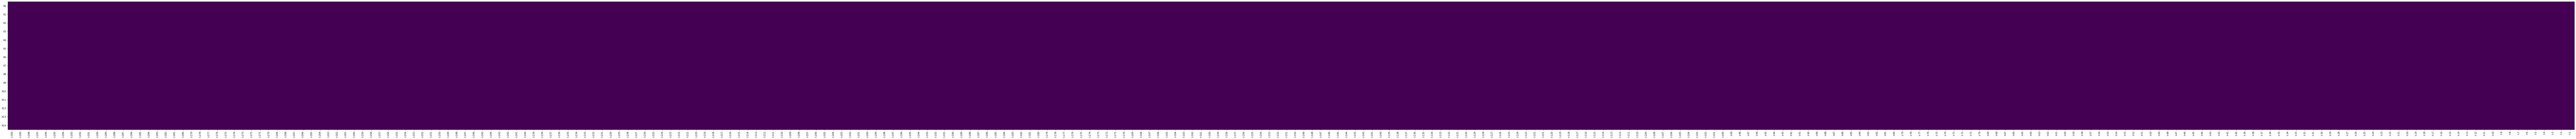

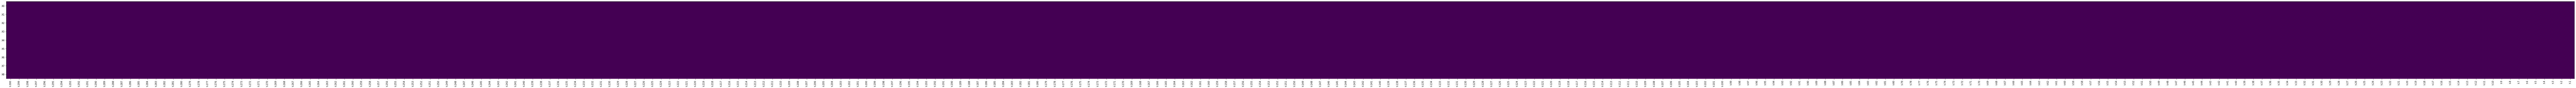

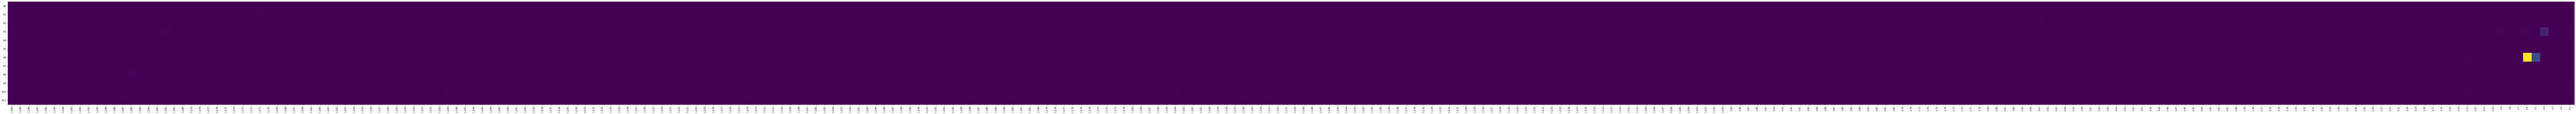

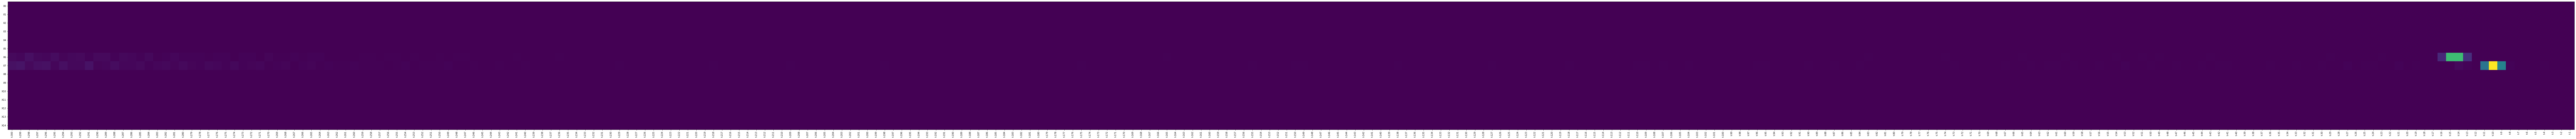

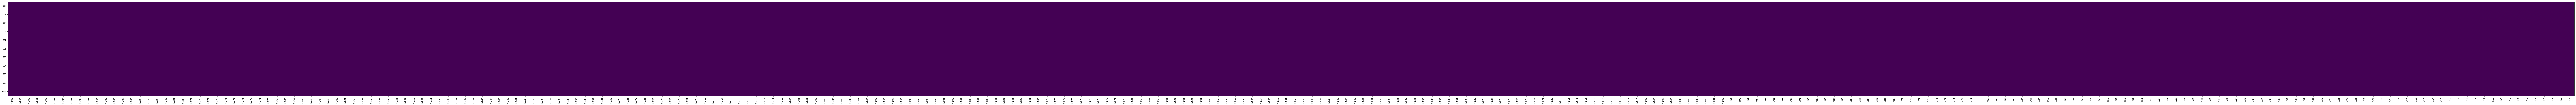

In [17]:
for i in range(number_of_experiments):
    fig, ax = plt.subplots(figsize=(200, 100))
    ax.imshow(maps[i].T)
    ax.set_xticks(np.arange(depth))
    ax.set_xticklabels(["t-{}".format(i) for i in range(depth,0,-1)], rotation=90)
    ax.set_yticks(np.arange(Xs[i].shape[1]))
    ax.set_yticklabels(["X{}".format(i) for i in range(Xs[i].shape[1])])
    plt.show()